In [115]:
import jax
import jax.numpy as jnp
from jax import jit, grad, jacfwd, hessian
import numpy as np
from numpy.linalg import inv, pinv
import matplotlib.pyplot as plt

from viewer import DoublePendViewer
import time

### Creating your own simulator for modeling robots

In this homework assignment, you will work on examples that give you the basics of how to create your own simulator to model most robotic systems. The end-goal of this assignment will be a simulation of a double pendulum which impacts a wall. Follow along each question and make sure to **read all the comments** as they are hints towards better ways to structure your code and will help with debugging. 

#### Q1. Writing your own integrators
In this question, you will write two integrators; the first is explicit Euler's method (the simplest integration), and the second is the RK4 integrator. Assume that the signature of the function passed to the stepping functions are of the form ``xdot = f(x)``. Also, assume that the stepping function only steps the solution over one single $\Delta t$.

In [116]:
def euler_step(f, x, dt):
    """
        Input:
            xdot = f(x) - function to be integrated, passed as f
            x - initial condition to the function 
            dt - time step 
        Output: 
            x[t+dt] 
    """
    return x + dt*f(x)

def rk4_step(f, x, dt):
    """
        Input:
            xdot = f(x) - function to be integrated, passed as f
            x - initial condition to the function 
            dt - time step 
        Output: 
            x[t+dt] 
    """
    # one step of runge-kutta integration
    k1 = dt * f(x)
    k2 = dt * f(x + k1/2)
    k3 = dt * f(x + k2/2)
    k4 = dt * f(x + k3)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

#### Double pendulum system

Below you are given the dynamics of a double pendulum (or a 2R robot arm) as shown in the figure below.  
<img src="./double_pend.png" width="420">

Note that the middle angle is measured *relative* to the previous link. 

The kinetic and potential energies of the system are given as 

$$
\begin{align}
    K & = \frac{1}{2} \dot{p}_1^\top m_1 \dot{p}_1 + \frac{1}{2} \dot{p}_2^\top m_2 \dot{p}_2 \\ 
    &=\frac{1}{2} (m_1 + m_2) l_1^2 \dot{q}_1^2 + \frac{1}{2} m_2 l_2 (\dot{q}_1 + \dot{q}_2)^2 + m_2 l_1 l_2 \dot{q}_1 (\dot{q}_1 + \dot{q}_2) \cos(q_2) \\ 
    V & = m_1 g y_1 + m_2 g y_2 = -(m_1+m_2)g l_1 \cos(q_1) - m_2 g l_2 \cos(q_1 + q_2) \\ 
    L(q, \dot{q}) & = K-V
\end{align}
$$
where $q = [q_1, q_2]^\top=[\theta_1, \theta_2]^\top$ and $p_1, p_2$ are the $x,y$ positions of the link mass.

Solving for the Euler-Lagrange Equations we get the following compact manipulator dynamics

$$
\begin{equation}
M(q) \ddot{q} + C(q, \dot{q})\dot{q} + G(q, \dot{q}) = Bu
\end{equation}
$$
where $Bu=0$ is the control input to the robot (in this case it is zero), and 

$$
\begin{align}
M(q) &= 
    \begin{bmatrix}
        (m_1 + m_2) l_1^2 + m_2 l_2^2 + 2 m_2 l_1 l_2 c_2 & m_2 l_2^2 + m_2 l_1 l_2 c_2 \\ 
        m_2 l_2^2 + m_2 l_1 l_2 c_2 & m_2 l_2^2 
    \end{bmatrix} \\ 
C(q, \dot{q}) &= 
    \begin{bmatrix}
        0 & - m_2 l_1 l_2 (2 \dot{q}_1 + \dot{q}_2) s_2 \\ 
        0 & -m_2 l_1 l_2 \dot{q}_1 s_2
    \end{bmatrix} \\ 
G(q, \dot{q}) &= 
    \begin{bmatrix}
        - g (m_1 + m_2) l_1 s_2 - g m_2 l_2 s_{12} \\ 
        -m_2 l_1 l_2 (\dot{q}_1 + \dot{q}_2) \dot{q}_1 s_2 - g m_2 l_2 s_{12}
    \end{bmatrix} \\ 
\end{align}
$$

These analytical equations are given below: 


In [117]:
l1 = 1.0
l2 = 1.0 
m1 = 1.0 
m2 = 1.0
g = 9.81

def K_analytical(q,qdot):
    return 0.5*(m1+m2)*l1**2*qdot[0]**2 \
            + 0.5 * m2*l2**2*(qdot[0]+qdot[1])**2 \
            + m2*l1*l2*qdot[0]*(qdot[0] + qdot[1])*np.cos(q[1])

def V_analytical(q):
    return -(m1 + m2) * g * l1 * np.cos(q[0]) - m2 * g * l2 * np.cos(q[0]+q[1])

def L_analytical(q, qdot):
    return K_analytical(q, qdot) - V_analytical(q)

def M_analytical(q):
    th1, th2 = q
    c2 = np.cos(th2)
    return np.array([
        [(m1+m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*c2, m2*l2**2 + m2*l1*l2*c2],
        [m2*l2**2 + m2*l1*l2*c2, m2*l2**2]
    ])

def C_analytical(q, qdot):
    th1, th2 = q
    th1d, th2d = qdot
    s2 = np.sin(th2)
    return np.array([
        [0.0, -m2*l1*l2*(2*th1d+th2d)*s2],
        [0.0, -m2*l1*l2*th1d*s2]
    ])

def G_analytical(q, qdot):
    th1, th2 = q
    th1d, th2d = qdot
    s1 = np.sin(th1)
    s2 = np.sin(th2)
    s12 = np.sin(th1+th2)
    return np.array([
            -9.81 * (m1+m2)*l1*s1 + -9.81 * m2*l2*s12,
            -m2*l1*l2*(th1d + th2d)*th1d*s2 - 9.81 * m2*l2*s12
    ])



#### Q2. Constructing the state and $\dot{x} = f(x)$
Using the manipulator equations, convert the dynamics into a first order differential equation. Use the defined dynamic functions above. 

In [118]:
def f_analytical(state):
    """
        Input: 
            state = x = [q, qdot] -- the state of the system 
        Output: 
            xdot
    """
    q, qdot = np.split(state, 2)
    qddot = np.linalg.pinv(M_analytical(q)) \
            @ (G_analytical(q, qdot) - C_analytical(q, qdot) @ qdot )
    return np.concatenate([qdot, qddot])

#### Q3. Simulate the system.
Given an initial condition $x_0 = [q_0, \dot{q}_0]^\top$, integrate the system for a given $\Delta t$ and final time $t_f$. Plot the results with the function below. You can also visualize the example using the double pendulum visualizer for debugging. Simulate using the euler_step and the rk4_step created previously. Plot results below. 

In [119]:
trajectory = {
        'euler' : [], 'euler_L' : [],
        'rk4' : [], 'rk4_L' : []
}

dt  = 0.005
tf  = 4
N   = int(tf/dt)

q0      = [0.6, 1.2]
qdot0   = [-1.6, 0.]
x0 = np.array(q0+qdot0) # <-- this is a list addition, not vector (acts like append for lists. Does not work with ndarray types)
x0E = x0.copy() 
x0R = x0.copy()

debug = False
if debug is True:
    viewer = DoublePendViewer()
    viewer.open()

for t in range(N):
    trajectory['euler'].append(x0E[:2])
    trajectory['euler_L'].append(L_analytical(*np.split(x0E,2)))
    trajectory['rk4'].append(x0R[:2])
    trajectory['rk4_L'].append(L_analytical(*np.split(x0R,2)))

    x0E = euler_step(f_analytical, x0E, dt)
    x0R = rk4_step(f_analytical, x0R, dt)

    if debug:
        ### need to choose which state to debug
        _x = x0E
        q, qdot = np.split(_x, 2)
        viewer.render(q)
        time.sleep(dt)


#### Plotting Function

Text(0, 0.5, 'L')

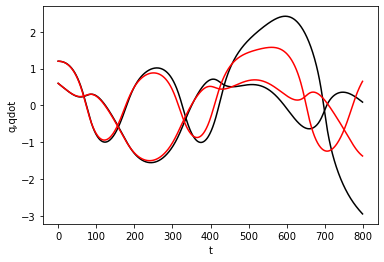

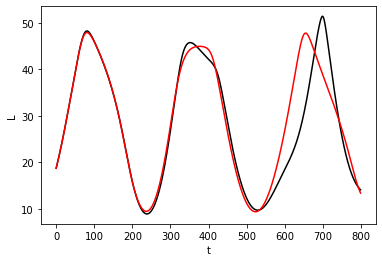

In [120]:
plt.figure(1)
plt.plot(trajectory['euler'], 'k')
plt.plot(trajectory['rk4'], 'r')
plt.xlabel('t')
plt.ylabel('q,qdot')

plt.figure(2)
plt.plot(trajectory['euler_L'], 'k')
plt.plot(trajectory['rk4_L'], 'r')
plt.xlabel('t')
plt.ylabel('L')

### Numerically derived dynamics

In these next set of problems, you will construct the equations of motion of a system (like the double pendulum before) numerically. You will be using the jax library, and the jax numpy ``jnp`` rather than ``np`` to create arrays and enable automatic differentiation. 

Our goal will be to construct the dynamics of a robotic system through construction of the Lagrangian. Recall the Euler-Lagrange equations are given as 

$$
\begin{equation}
    \frac{d}{dt} \frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = Bu
\end{equation}
$$
which can be expanded as 
$$
\begin{equation}
    \frac{\partial^2 L}{\partial \dot{q} \partial \dot{q}} \ddot{q} 
    + \frac{\partial^2 L}{\partial \dot{q} \partial q} \dot{q} - \frac{\partial L}{\partial q} = Bu
\end{equation}
$$
where $M(q) = \frac{\partial^2 L}{\partial \dot{q} \partial \dot{q}}$, $C(q,\dot{q})= \frac{\partial^2 L}{\partial \dot{q} \partial q}$, and $G(q,\dot{q}) = \frac{\partial L}{\partial q}$. Note that for the double pendulum $Bu = 0$ i.e., there is no control input. 

If we can compute the Lagrangian $L(q, \dot{q})$ we can take the derivatives with respect to the arguments and obtain the required exact numerical representation of the dynamics without having to do any math! The following questions build up code to do exactly that! 

### Q4. Computing the mass velocities. 
Recall that $K = \sum_i \dot{p}_i^\top M_i \dot{p}_i$ is the kinetic energy of a system where $p_i$ is the position of the $i^\text{th}$ center of mass and $M_i$ is the mass matrix. (Inertia can also be readily included by extending the kinetic energy with orientation of the mass at the location $p_i$). 

In addition, recall that $\dot{v}_i = J_i(q) \dot{q}$ is the relationship between the velocity at a reference frame $i$ and the velocity of the robot's joints $\dot{q}$ (also referred to as generalized coordinates). We will use this fact to calculate $\dot{p}_i = J_i(q) \dot{q}$ simply by knowing how the masses of each link are related to each other through the configuration of the robot.

It is easy to generalize this to transformation matrices, but we will instead hard-code the position of the mass of the link of the double pendulum above. Because the pendulum is only written with masses, we will automatically derive out inertia terms simply due to the location of the mass. Code up the positions of the masses of the double pendulum using ``jnp`` arrays to enable calculations of the jacobians.

In [121]:
def p1(q):
    """
        Position of the first mass
        Input: 
            q - joints 
        Output: 
            x_1 - position of mass 1 
    """
    th1, th2 = q
    return jnp.array([
        l1 * jnp.sin(th1),
        -l1 * jnp.cos(th1)
    ])

def p2(q):
    """
        Position of the second mass
        Input: 
            q - joints 
        Output: 
            x_2 - position of mass 2
    """
    th1, th2 = q
    return p1(q) + jnp.array([
        l2 * jnp.sin(th1+th2),
        -l2 * jnp.cos(th1+th2)
    ])

"""
    The function jacfwd is a wrapper around a function f and creates 
    a new function that outputs the derivative dfdx, with x as input.
    These functions compute the derivative of the mass location 
    with respect to the robot joint inputs q. Note this is 
    the jacobian J(q) = dfdq where v = J(q)qdot is velocity.  
"""
jac_p1 = jacfwd(p1)
jac_p2 = jacfwd(p2)

#### Q5. Compute the Kinetic and potential energies.

Use the fact that $v_i = J_i(q) \dot{q}$ to find the velocities of each center of mass. 

In [126]:
def K_derived(q, qdot):
    _M1 = np.diag([m1,m1])
    _M2 = np.diag([m2,m2])
    v1 = jac_p1(q) @ qdot 
    v2 = jac_p2(q) @ qdot 
    return 0.5 * v1 @ _M1 @ v1 + 0.5 * v2 @ _M2 @ v2

def V_derived(q):
    return m1 * 9.81 * p1(q)[1] + m2 * 9.81 * p2(q)[1]

#### Check solutions with analytically derived kinetic and potential energies

In [127]:
q_test = np.array([0.7, 0.6])
qdot_test = np.array([7.8,6.07])

print(np.isclose(K_derived(q_test, qdot_test), K_analytical(q_test, qdot_test)))
print(np.isclose(V_derived(q_test), V_analytical(q_test)))

True
True


### Q6. Compute dynamic terms
Using the functions ``hessian``, ``jacfwd``, calculate the derived $M(q), C(q, \dot{q}), G(q, \dot{q})$ matrices. Check against the analytically derived matrices. It is recommended to read the documentation for these two functions.

In [128]:
def L_derived(q, qdot):
    return K_derived(q, qdot) - V_derived(q)

def M_derived(q, qdot):
    return hessian(L_derived, 1)(q, qdot)

def C_derived(q, qdot):
    return jacfwd(jacfwd(L_derived,1),0)(q, qdot)

def G_derived(q, qdot):
    return jacfwd(L_derived, 0)(q, qdot)

#### Check solutions with analytically derived kinetic and potential energies

In [129]:
q_test = np.array([0.7, 0.6])
qdot_test = np.array([.8,1.07])
print(np.isclose(
            L_derived(q_test, qdot_test), 
            L_analytical(q_test, qdot_test)
        ).all()
)
print(np.isclose(
            M_derived(q_test, qdot_test), 
            M_analytical(q_test)
        ).all()
)
print(np.isclose(
            C_derived(q_test, qdot_test), 
            C_analytical(q_test, qdot_test),
            atol=1e-6 # jax using 32-bit floating point, numpy uses 64-bit
        ).all()
)
print(np.isclose(
            G_derived(q_test, qdot_test), 
            G_analytical(q_test, qdot_test)
        ).all()
)


True
True
True
True


#### Q7. Constructing the state and $\dot{x} = f(x)$
Using the derived dynamic equations, convert the dynamics into a first order differential equation. Use the derived dynamic functions above. 

In [45]:
def f_derived(state):
    q, qdot = jnp.split(state, 2)
    qddot = jnp.linalg.pinv(M_derived(q, qdot)) \
            @ (G_derived(q, qdot) - C_derived(q,qdot) @ qdot )
    return jnp.concatenate([qdot, qddot])


#### Q8. Simulate the system.
Given an initial condition $x_0 = [q_0, \dot{q}_0]^\top$, integrate the system for a given $\Delta t$ and final time $t_f$. Plot the results with the function below. You can also visualize the example using the double pendulum visualizer for debugging. Simulate using the rk4_step created previously. Plot results and compare with the analytically constructed dynamics below. 

In [133]:
trajectory = {
        'analytical' : [], 'analytical_L' : [],
        'derived' : [], 'derived_L' : []
}

dt  = 0.005
tf  = 4
N   = int(tf/dt)

q0      = [0.6, 1.2]
qdot0   = [-1.6, 0.]
x0 = np.array(q0+qdot0) # <-- this is a list addition, not vector (acts like append for lists. Does not work with ndarray types)
x0A = x0.copy() 
x0D = x0.copy()

debug = False
if debug is True:
    viewer = DoublePendViewer()
    viewer.open()

for t in range(N):
    trajectory['analytical'].append(x0A[:2])
    trajectory['derived'].append(x0D[:2])
    trajectory['analytical_L'].append(L_analytical(*np.split(x0A,2)))
    trajectory['derived_L'].append(L_derived(*np.split(x0D,2)))

    x0A = rk4_step(f_analytical, x0A, dt)
    x0D = rk4_step(f_derived, x0D, dt)

    if debug:
        ### need to choose which state to debug
        _x = x0D
        q, qdot = np.split(_x, 2)
        viewer.render(q)
        time.sleep(dt)

#### Plotting Function

Text(0, 0.5, 'L')

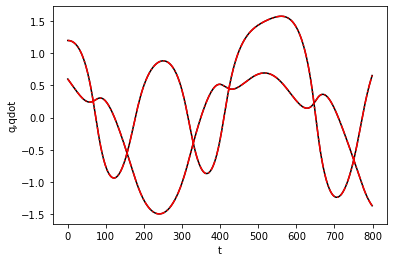

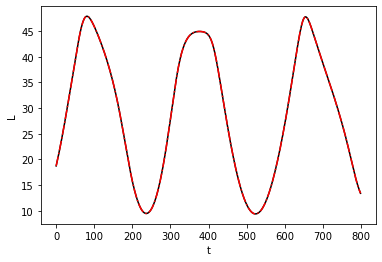

In [136]:
plt.figure(1)
plt.plot(trajectory['analytical'], 'k')
plt.plot(trajectory['derived'], 'r-.')
plt.xlabel('t')
plt.ylabel('q,qdot')

plt.figure(2)
plt.plot(trajectory['analytical_L'], 'k')
plt.plot(trajectory['derived_L'], 'r-.')
plt.xlabel('t')
plt.ylabel('L')

#### Q9. Contact 
We will now introduce contact into the problem! Consider a vertical wall which only impacts the second mass with it crosses the $y$ axis. Write the following functions needed to compute contact. 


#### Q9.1 Guard/Indicator function 
First construct a function $\phi(q)$ where $\phi(q)>0$ means the mass is on the right side of the $y$ axis (i.e., $x>0$), $\phi(q) =0$ when the mass is in contact with the wall, and $\phi(q)<0$ when intersects the wall.

In [138]:
def phi(q):
    x,y = p2(q)
    return x-0.1

#### Q9.2 Contact location and jacobian
Write a function that computes the contact location of the mass in the world coordinate when $\phi(q)<=0$. Using ``jacfwd``, compute the contact jacobian. 

In [139]:
def contact_loc(q):
    return p2(q)
contact_jac = jacfwd(contact_loc)

#### Q9.3 Velocity reset map 
Write a function that computes the post impact velocity $\dot{q}^+$ given the contact velocity $\dot{q}^-$. Use the derived dynamics and the contact jacobian.

In [140]:
def reset_map(q, qdot):
    J = contact_jac(q)
    _M_inv = inv(M_derived(q, qdot))
    return (np.eye(qdot.shape[0]) - _M_inv@J.T@np.diag([2.0,2.0])@pinv(J@_M_inv@J.T)@J)@qdot

#### Q10 Simulate contact
Given an initial condition $x_0 = [q_0, \dot{q}_0]^\top$, integrate the system for a given $\Delta t$ and final time $t_f$. Check for contact at each step. If a contact is detected, use the ``reset_map`` function to compute the post-impact velocities $\dot{q}$. Plot the results with the function below. You can also visualize the example using the double pendulum visualizer for debugging. Simulate using the rk4_step created previously. 

In [143]:
trajectory = {
        'derived' : [], 'derived_L' : []
}

dt  = 0.005
tf  = 4
N   = int(tf/dt)

q0      = [0.6, 1.2]
qdot0   = [-1.6, 0.]
x0 = np.array(q0+qdot0) # <-- this is a list addition, not vector (acts like append for lists. Does not work with ndarray types)

debug = True
if debug is True:
    viewer = DoublePendViewer()
    viewer.open()

for t in range(N):
    trajectory['derived'].append(x0[:2])
    trajectory['derived_L'].append(L_derived(*np.split(x0,2)))

    x0 = rk4_step(f_derived, x0, dt)

    q, qdot = np.split(x0,2)
    if phi(q) <= 0:
        qdot = reset_map(q, qdot)
        x0 = np.concatenate([q, qdot])
        

    if debug:
        ### need to choose which state to debug
        _x = x0
        q, qdot = np.split(_x, 2)
        viewer.render(q)
        time.sleep(dt)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7026/static/


#### Plotting function

Text(0, 0.5, 'L')

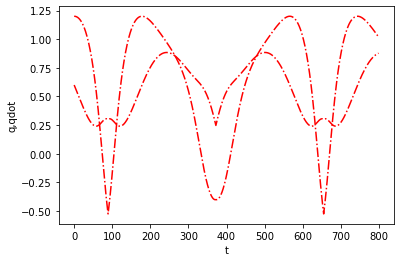

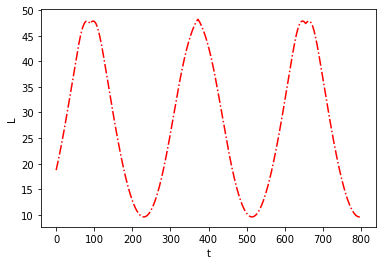

In [144]:
plt.figure(1)
plt.plot(trajectory['derived'], 'r-.')
plt.xlabel('t')
plt.ylabel('q,qdot')

plt.figure(2)
plt.plot(trajectory['derived_L'], 'r-.')
plt.xlabel('t')
plt.ylabel('L')